# Прогноз продаж игр

В рамках работы нам предстоит анализ большого пула информации о продаже игр до 2016 года (названия,жанры, год выпуска, продажи по регионам, платформы и рейтинги).

Информация представлена ввиде таблицы со столбцами:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Определяет рейтинг и возрастную категорию.

**Краткий план работ:**
- определить акутальный период на анализа;
- рассмотреть продажи игры по платформам и жанру, определить перспективные платформы;
- оценить влияние оценок пользователей и критиков, а так же рейтинга ESRB на продажи;
- определить ТОП-5 платформ и жанров в регионах;
- проверить гипотезы:
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    - Средние пользовательские рейтинги жанров Action и Sports разные.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

Взглянем на данные:

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Пропуски:**
- Ввиду относительного небольшого количества пропусков (до 1,6 % от всех данных) в столбцах имени, жанра и года выпуска игры, удалим строки с этими пропусками
- пропуски в столбцах оценок и рейтинга удалять нельзя из-за их многочисленности, а их воспроизведение их не представляется возможным (или не имеет смысла)

Пропуски могли быть вызваны разными причинами, оценки - тем, что некоторые игры были популярны еще до того, как стала популярной и возможной практика проставления оценок и отзывов (особенно у рядовых пользователей). Кроме того, пропуски могли быть вызваны техническими тонкостями при сборе информации или объединении в общий датасет, либо в исходных базах данных определенная информация могла не собираться вообще

**Взглянем на данные с пропусками**

Пропуски в имени:

In [5]:
df[df.Name.isnull()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Два пропуска в столбце с именем совпали с двумя пропусками в жанре. Их можно смело удалять

Пропуски в дате релиза:

In [6]:
pd.options.display.max_rows = 300 # увеличиваем максимальное количество выводимых строк
df[df.Year_of_Release.isnull()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


In [7]:
pd.options.display.max_rows = 10 # возвращаем максимальное количество выводимых строк к 10

Года выпуска, которые можно было бы "вытащить" из названий самих игр, не подходят для актуального (свежего) прогноза игр. Поэтому их можно удалить:

In [8]:
df.dropna(subset=['Name', 'Genre', 'Year_of_Release'], inplace=True) # удаляем строки с пропусками
df['Year_of_Release'] = df['Year_of_Release'].astype('int') # меняем тип данных у года выпуска

Приведем названия столбцов в нижний регистр:

In [9]:
df.columns = df.columns.str.lower()
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


Взглянем на платформы:

In [10]:
df['platform'].value_counts()

PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
        ... 
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, Length: 31, dtype: int64

Подметить нечего, кроме наличия просто PS и PS2, PS3... Может быть кто-то подразумевал PS как общую категорию? Взглянем на даты выпуска игр с категорией PS:

In [11]:
df.query('platform == "PS"')['year_of_release'].value_counts()

1998    248
1999    200
1997    188
1996    164
2000    160
1995     99
2001     91
2002     20
1994     17
2003      3
Name: year_of_release, dtype: int64

Похоже, что это все-таки именно первая консоль PS, а не категория

**Взглянем на оценки критиков:**

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
       ... 
29.0      3
20.0      3
21.0      1
13.0      1
17.0      1
Name: critic_score, Length: 81, dtype: int64

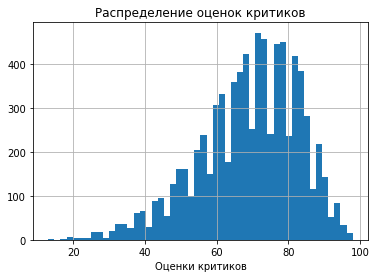

In [12]:
df['critic_score'].hist(bins=50).set_title('Распределение оценок критиков')
plt.xlabel('Оценки критиков')
df['critic_score'].value_counts()

Большое количество значений "tbd", интернет говорит, что это означает "Подлежит определению", что тоже является пропуском. Заменим эти значения на пропуски и приведем данные столбца в числовой тип:


In [13]:
df['user_score'] = df['user_score'].replace('tbd', np.nan) # меняем на пропуски
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce') # меняем тип данных с методом обработки ошибок 'coerce'

**А теперь взглянем на оценки пользователей':**

7.8    322
8.0    285
8.2    276
8.3    252
7.5    249
      ... 
9.6      2
0.6      2
1.9      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64

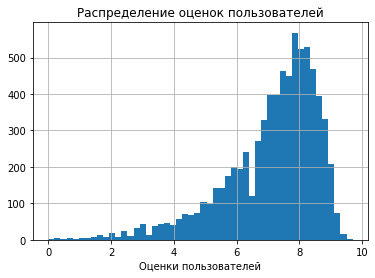

In [14]:
df['user_score'].hist(bins=50).set_title('Распределение оценок пользователей')
plt.xlabel('Оценки пользователей')
df['user_score'].value_counts()

Достаточно правдоподобно.

### Посчитаем суммарные продажи во всех регионах:

In [15]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


**Вывод**

Мы рассмотрели данные и провели их предобработку:
- привели названия столбцов к нижнему регистру;
- некоторые обнаруженные пропуски удалены, некоторые (оценки и рейтинг) оставили без измнений;
- посчитано суммарное количество проданных копий каждой игры.

## Анализ

### Рассмотрим, сколько игр выпускалось в разные годы:

Text(0.5, 0, 'Год выпуска игры')

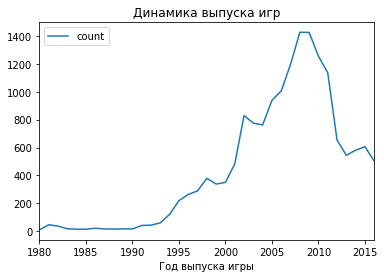

In [16]:
releases_per_year = df.pivot_table(index='year_of_release', values='name', aggfunc = 'count')
releases_per_year.rename(columns={'name': 'count'}, inplace=True)
releases_per_year.plot().set_title('Динамика выпуска игр')
plt.xlabel('Год выпуска игры')

### Определим, какие платформы лидируют по продажам, растут или падают и выберем несколько потенциально прибыльных платформ




Необходимо определить временной промежуток, который мы будем рассматривать.

Для этого сначала **определим ТОП-10 платформ по суммарным продажам за период:**

In [17]:
top_10 = (df.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False).head(10))
top_10

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


И посмотрим на их жизненные циклы:

Text(0.5, 0, 'Год')

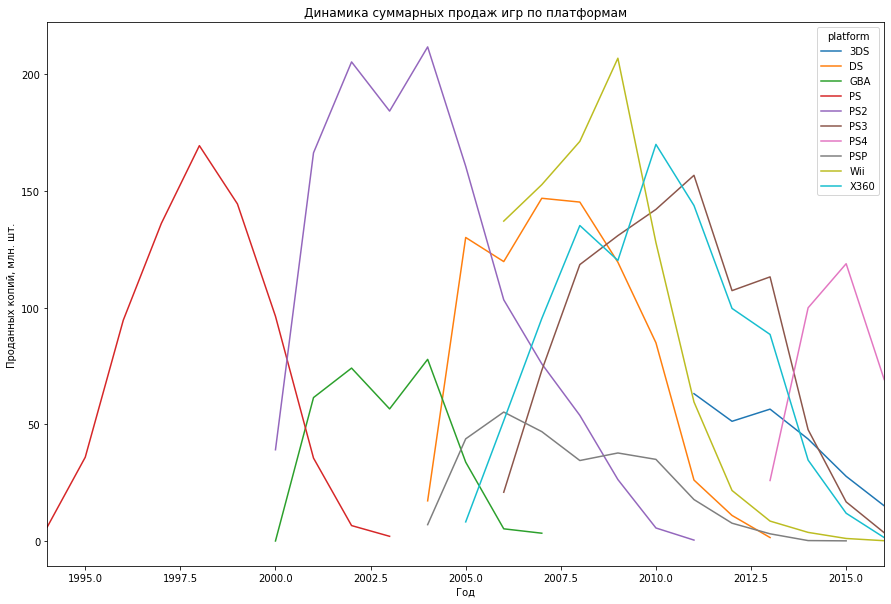

In [18]:
(df.query('platform in @top_10.index')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(15,10), xlim=(1994, 2016)).set_title('Динамика суммарных продаж игр по платформам')
)
plt.ylabel('Проданных копий, млн. шт.')
plt.xlabel('Год')

**Определим среднюю продолжительность жизни платформ:**

,year_of_release
platform,
3DS,5
DS,28
GBA,7
PS,9
PS2,11
PS3,10
PS4,3
PSP,11
Wii,10


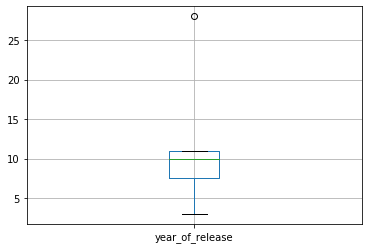

In [19]:
lifespan_platforms = (df.query('platform in @top_10.index')
    .pivot_table(index='platform', values='year_of_release', aggfunc = lambda x: x.max() - x.min()))
lifespan_platforms.boxplot()
lifespan_platforms

Видим выброс - значение платформы DS. Посчитаем среднюю продожительность без этого значения:

In [20]:
lifespan_platforms.query('platform != "DS"')['year_of_release'].mean()

8.555555555555555

Так как нашей задачей является не исторический экскурс по играм всех времен, то и **рассматривать будем 2012-2016 года** (чуть меньше половины средней продожительности жизни платформ).

**Рассмотрим данные на этом временном отрезке**

Отфильтруем данные по году выпуска:

In [21]:
df_new = df.query('year_of_release >= 2012')

Посмтроим график продаж игр всех платформ по годам:

Text(0.5, 0, 'Год')

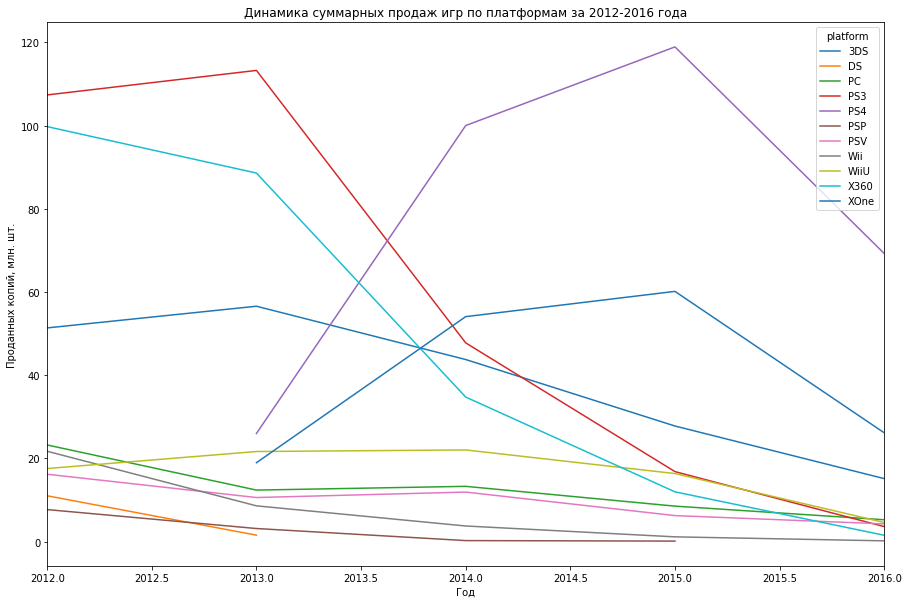

In [22]:
(df_new.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(15,10)).set_title('Динамика суммарных продаж игр по платформам за 2012-2016 года')
)
plt.ylabel('Проданных копий, млн. шт.')
plt.xlabel('Год')

Судя по данным, никакая из платформ не показывает положительную динамику в 2016 году. Возможно, дело в том, что данные представлены не на конец 2016 года. В рамках анализа не будем рассматривать поведение граффика на этом участке.

**Вывод**

**На временном отрезке 2013-2015 ростом продаж выделяются платформы XOne и PS4**, их вполне можно считать **потенциально прибыльными**, тогда как остальные платформы в это время теряют свою популярность. В 2014 году видна точка после которой продажи на PS4 превзошли PS3, сменилась "эпоха"?)

В споре платформ XOne и PS4 **с сильным разрывом лидирует PS4, продав 100 и 118,9 млн. копий в 2014 и 2015 годах** против 54 и 60,1 млн. соотвественно

### Рассмотрим диаграмму размаха продаж по платформам

Text(0.5, 1.0, 'Диаграмма размаха продаж по платформам')

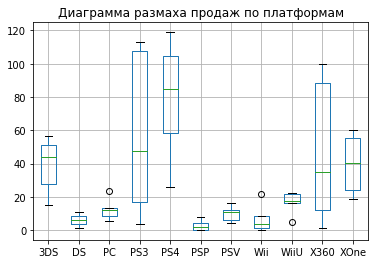

In [23]:
warnings.filterwarnings("ignore")
(df_new.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .boxplot()
    .set_title('Диаграмма размаха продаж по платформам')
)

Как мы видим, продажи игр и их медианы существенно разнятся на разных платформах. 

Вызвано это тем, что платформы имеют разную популярность и спрос у пользователей, так и конкретные игры внутри платформ показывают разнящиеся результаты. Кроме того, мы рассматриваем 2012-2016 года, когда некоторые платформы уже на "закате карьеры"

### Влияние отзывов пользователей и критиков на продажи

Для начала рассмотрим данные платформы PS3:

Text(0.5, 1.0, 'Общие продажи по платформе PS3')

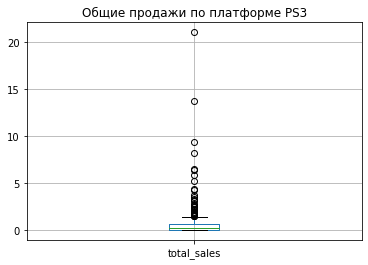

In [24]:
df_new.query('platform == "PS3"').boxplot('total_sales').set_title('Общие продажи по платформе PS3')

Видим выбросы (отдельные хиты продаж) среди игр, будем иметь это ввиду и взглянем на корреляцию продаж и оценок для этих данных:

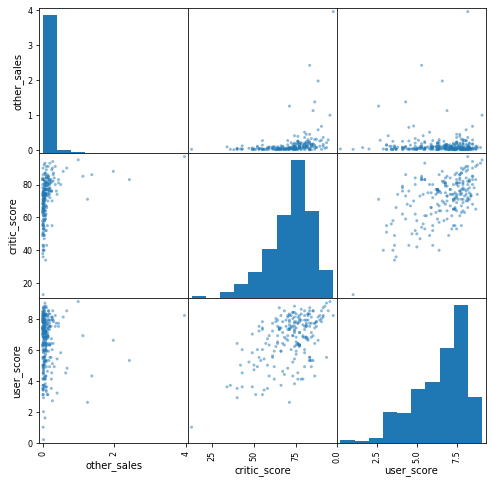

In [25]:
pd.plotting.scatter_matrix(df_new.query('platform == "PS3"')[['other_sales', 'critic_score', 'user_score']], figsize=(8, 8))
plt.show()

In [26]:
df_new.query('platform == "PS3"')[['other_sales', 'critic_score', 'user_score']].corr()

,other_sales,critic_score,user_score
other_sales,1.000000,0.312856,-0.004166
critic_score,0.312856,1.000000,0.539456
user_score,-0.004166,0.539456,1.000000


А теперь взглянем на эти же данные, но с отфильтрованными выбросами:

In [27]:
df_new.query('platform == "PS3" & total_sales < 2')[['other_sales', 'critic_score', 'user_score']].corr()

,other_sales,critic_score,user_score
other_sales,1.000000,0.418061,0.028553
critic_score,0.418061,1.000000,0.570797
user_score,0.028553,0.570797,1.000000


Как мы видим, корреляция выросла, но принципиально не измнилась. 

**Корреляция 0,42 у продаж с оценкой критиков близкая к средней, но, все-таки, слабая**

Взглянем на данные других платформ. Выделим 5 самых "живых" платформ:

In [28]:
top_5 = (df_new.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending=False).head(5))
top_5

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32


И взглянем на их корреляции:

In [29]:
print('Корреляция продаж игр:')
print()
for platform in top_5.index:
    print('- плтаформы', platform, 'с оценками:')
    print('Критиков: {:.2f}'.format(df_new.query('platform == @platform')['total_sales']
                                  .corr(df_new.query('platform == @platform')['critic_score'])), end =', ')
    print('Пользователей: {:.2f}'.format(df_new.query('platform == @platform')['total_sales']
                                  .corr(df_new.query('platform == @platform')['user_score'])))
    print('--------------------------------------')

Корреляция продаж игр:

- плтаформы PS4 с оценками:
Критиков: 0.41, Пользователей: -0.03
--------------------------------------
- плтаформы PS3 с оценками:
Критиков: 0.33, Пользователей: -0.01
--------------------------------------
- плтаформы X360 с оценками:
Критиков: 0.36, Пользователей: 0.01
--------------------------------------
- плтаформы 3DS с оценками:
Критиков: 0.32, Пользователей: 0.20
--------------------------------------
- плтаформы XOne с оценками:
Критиков: 0.42, Пользователей: -0.07
--------------------------------------


Картина аналогичная. Чуть бОльшая корреляция с оценками критиков у платформ PS4 и XOne.

Корреляция с оценками пользователей очень слабая.

Я еще раз проверил корреляции у этих платформ без выбросов - результаты аналогичные

**Вывод**

Если сравнивать влияние оценок пользователей и критиков на продажи игр, то выдеяются вторые:
- коэффициент корреляции продаж и оценок критиков - 0,33-0,42
- продаж и оценк пользователей - меньше 0,2
Таким образом, в большинстве случаев **влияние оценок пользователей и критиков на продажи игр оказывают среднее или слабое влияние**, либо это зависимость нелинейная

Хоть критики, по сравнению с простыми пользователями, более компетентны в своих оценках, и их оценки в какой-то степени могут сказаться и на продажах, но итоговый успех игр и платформ зависит от куда большего количества параметров.

### Распределение игр по жанрам

Рассмотрим распределение игр по жанрам с точки зрения продаж:

In [30]:
df_new.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)

,total_sales
genre,
Action,441.12
Shooter,304.73
Role-Playing,192.80
Sports,181.07
Misc,85.04
...,...
Fighting,44.49
Simulation,35.12
Adventure,29.43


**Вывод**
- ожидаемо **лидируют экшн и стрелялки, далее спортивные и ролевые игры**
- где-то **в середине оказались миск, гонки, платформеры и драки**
- Количеством проданных копий похвастаться не смогут **пазлы, стратегии, приключенческие игры и симуляторы**


## Определение портрета пользователей регионов NA, EU и JP

### ТОП-5 платформ каждого региона:

Создадим функцию определения ТОП-5 платформ с выводом в виде графика:

In [31]:
def plot_pie_platform(region):
    (df_new.pivot_table(index='platform', values=region, aggfunc='sum')
        .sort_values(region, ascending=False)
        .head(5)
        .plot(kind='bar', y=region).set_title(region))

Взглянем на ТОП-5 платформ каждого региона:

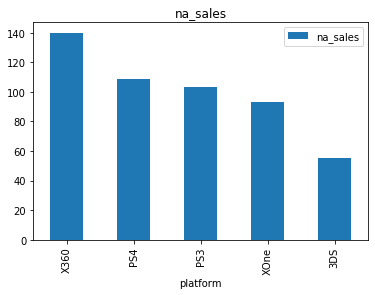

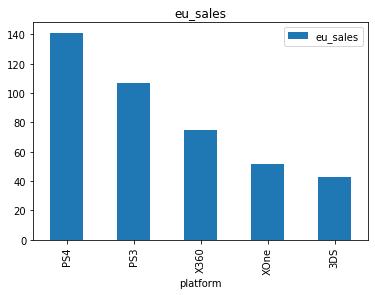

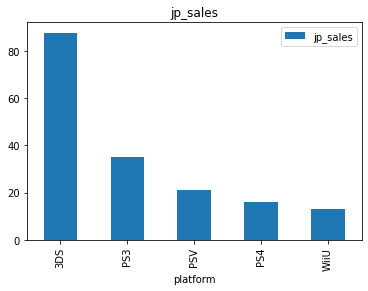

In [32]:
regoins = ['na_sales', 'eu_sales', 'jp_sales']
for region in regoins:
    plot_pie_platform(region)

**Вывод**

- популярность платформ разнится от региона к региону, что говорит о разных вкусах или особенностях внутреннего рынка, в СА любят X360, в Европе PS4, а в Японии 3DS, но при этом - PS3 близка всем регионам;
- самая популярная платформа Северной Америки - X360 не попала в ТОП-5 Японии;
- PS3, PS4 3DS - платформы, которые попали в ТОП-5 для каждого региона.

### ТОП-5 жанров каждого региона:

Аналогично плаформам создаем функцию вывода ТОП-4 жанров по регионам:

In [33]:
def plot_pie_genre(region):
    (df_new.pivot_table(index='genre', values=region, aggfunc='sum')
        .sort_values(region, ascending=False)
        .head(5)
        .plot(kind='bar', y=region).set_title(region))

Выводим ТОП-5 жанров для каждого региона:

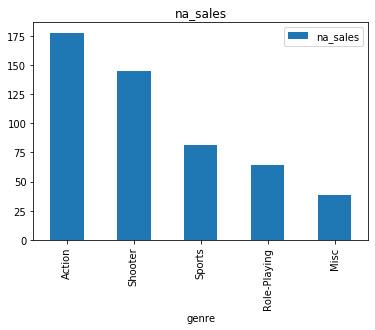

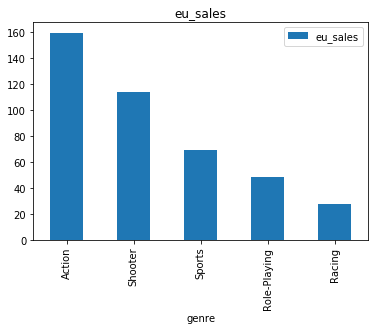

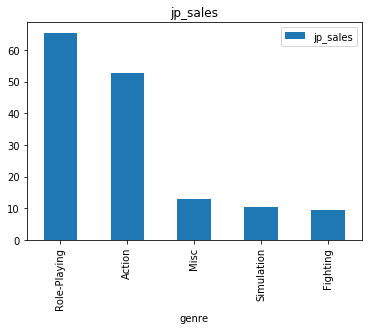

In [34]:
for region in regoins:
    plot_pie_genre(region)

**Вывод**

- **вкусы пользователей Европы и СА довольно близки** (только 5 место в СА занял миск, а в Европе - гонки), когда **первые четыре позиции - экшн, стрелялки, спорт и ролевые игры**
- японцы отдают предпочтение **ролевым играм, далее уверенно экшен**, а спорту и стрелялкам предпочитают **симуляторы и драки**

### Влияние рейтинга ESRB на продажи в регионах

Рейтинг ESRB отражает возрастную категорию, на которую расчитаны игры. Соответсвенно, что игры предназначенные для детей младшего возраста и игры для 18+ - принцпиально разные, как и их показатели.

Взглянем на продажи игр рейтинга ESRB в каждом регионе:

In [35]:
df_new['rating'] = df_new['rating'].fillna('Без рейтинга') #обозначим все игры с пропусками
df_new.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
Без рейтинга,91.50,108.84,103.31


**Вывод:**

**Выбор возрастной категории**, на которую ориентирована игра, **сильно влияет на ее продажи**, что хорошо отражается в таблице

## Гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Гипотезу из задания берем за нулевую, а за альтернативную неравенство оценок пользователей:
- Н0 - средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**
- Н1 - средние пользовательские рейтинги платформ Xbox One и PC **разные**

Сравним дисперсии рассматриваемых данных:

In [36]:
df_good = df_new.dropna(subset=['user_score']) # сначала удалим пропуски в столбце с оценками пользователей
print('Дисперсия оценки для Xbox One: {:.2f}'.format(np.var(df_good.query('platform == "XOne"')['user_score'], ddof=1)))
print('Дисперсия оценки для PC: {:.2f}'.format(np.var(df_good.query('platform == "PC"')['user_score'], ddof=1)))

Дисперсия оценки для Xbox One: 1.91
Дисперсия оценки для PC: 2.77


Разница между ними есть, поэтому зададим "equal_var = False"

In [37]:
alpha = .05

results = st.ttest_ind(df_good.query('platform == "XOne"')['user_score'], 
                       df_good.query('platform == "PC"')['user_score'], equal_var = False)

print('p-значение', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не удалось')

p-значение 0.5489537965134912
Нулевую гипотезу отвергнуть не удалось


Судя по Р-значению, вероятность того, что **средние показатели оценок пользователей платформ Xbox One и PC равны - очень велика**

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

За нулевую гипотезу берем равенство пользовательских оценок жанров, а за альтернативную - гипотезу из задания (неравенство оценок)

- Н0 - средние пользовательские рейтинги жанров Action и Sports одинаковые
- Н1 - средние пользовательские рейтинги разные

Сравним дисперсии рассматриваемых данных:

In [38]:
print('Дисперсия оценки для Action: {:.2f}'.format(np.var(df_good.query('genre == "Action"')['user_score'], ddof=1)))
print('Дисперсия оценки для Sports: {:.2f}'.format(np.var(df_good.query('genre == "Sports"')['user_score'], ddof=1)))

Дисперсия оценки для Action: 1.89
Дисперсия оценки для Sports: 3.02


Разница между ними есть, поэтому зададим "equal_var = False"

In [39]:
alpha = .05

results = st.ttest_ind(df_good.query('genre == "Action"')['user_score'], 
                       df_good.query('genre == "Sports"')['user_score'], equal_var = False)

print('p-значение', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не удалось')

p-значение 4.24307776572644e-20
Отвергаем нулевую гипотезу


Нулевою гипотезу подтвердить не удалось. **Велика вероятность того, что средние пользовательские рейтинги жанров Action и Sports разные.**

## Вывод

1. В рамках работ нами были рассмотрены данные и проведена их предобработка
---
2. Рассмотрена динамика выпуска игр по годам и определен **временной промежуток для анализа - 2010-2016**
---
3. Определены **потенциально прибыльные платформы**:
    - ростом продаж **выделяются платформы XOne и PS4**, их вполне можно считать **потенциально прибыльными**, где **с сильным разрывом лидирует PS4, продав 100 и 118,9 млн. копий в 2014 и 2015 годах** против 54 и 60,1 млн. соотвественно
---
4. Проведена **оценка влияния отзывов пользователей и критиков на продажи**. 
    - в большинстве случаев **оценки пользователей и критиков на продажи игр оказывают среднее или слабое влияние**, либо это зависимость нелинейная;
    - коэффициент корреляции продаж и оценок критиков - 0,33-0,42;
    - продаж и оценк пользователей - меньше 0,2.
---
5. Рассмотрено **распределение игр по жанрам**:
    - **лидируют экшн и стрелялки, далее спортивные и ролевые игры**
    - где-то **в середине оказались миск, гонки, платформеры и драки**
    - Количеством проданных копий похвастаться не смогут **пазлы, стратегии, приключенческие игры и симуляторы**
---
6. Составлен **портрет пользователя регионов NA, EU и JP**
    - платформы:
        - популярность платформ разнится от региона к региону, что говорит о разных вкусах или особенностях внутреннего рынка, в СА любят X360, в Европе PS4, а в Японии 3DS, но при этом - PS3 близка всем регионам;
        - самая популярная платформа Северной Америки - X360 вообще не попала в ТОП-5 Японии;
        - PS3, PS4 3DS - платформы, которые попали в ТОП-5 для каждого региона.
    - жанры:
        - **вкусы пользователей Европы и СА довольно близки** (только 5 место в СА занял миск, а в Европе - гонки), когда **первые четыре позиции - экшн, стрелялки, спорт и ролевые игры**
        - **японцы отдают предпочтение ролевым играм, далее уверенно экшен**, а спорту и стрелялкам предпочитают **симуляторы и драки**
---
7. Проведена **оценка влияния рейтинга ESRB на продажи в регионах**:
    - **выбор возрастной категории**, на которую ориентирована игра, **сильно влияет на ее продажи**
---
8. Проверены **гипотезы**:
    - вероятность того, что **средние показатели оценок пользователей платформ Xbox One и PC равны - очень велика**
    - вероятность того, что **средние пользовательские рейтинги жанров Action и Sports разные - очень велика**


## Рекомендации

При планировании бюджетов я бы порекомендовал **сделать упор на платформы XOne и PS4**.

С точки зрения **жанров** продавать лучше то, что уже хорошо продается:
- **экшн, стрелялки, спорт для СА и Европы;**
- **ролевые игры и экшн для Японии.**

Но не стоит забывать, что анализ сделан опираясь только на количество **проданных копий**, то есть даже не на выручку и, тем более, не на прибыль и не на рентабельность